Loaded pretrained weights for efficientnet-b7
병렬 처리 시간: 569.7700860500336초
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\manchester-city-logo-vector-download-400x400.jpg and target image: 1.0
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\new-fc-barcelona-logo.png and target image: 0.61503273
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\kv-mechelen-vector-logo-400x400.png and target image: 0.61141604
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\cs-mioveni-vector-logo-400x400.png and target image: 0.6007634
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\ac-cuneo-1905-vector-logo-400x400.png and target image: 0.5862388
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\luton-town-fc-vector-logo-400x400.png and target image: 0.5854875
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\Porsche-logo-01.png and target image: 0.57890594
Similarity between C:\Users\DGU_ICE\FindOwn\ImageDB\Logos\black-sabbath-logo-vector-

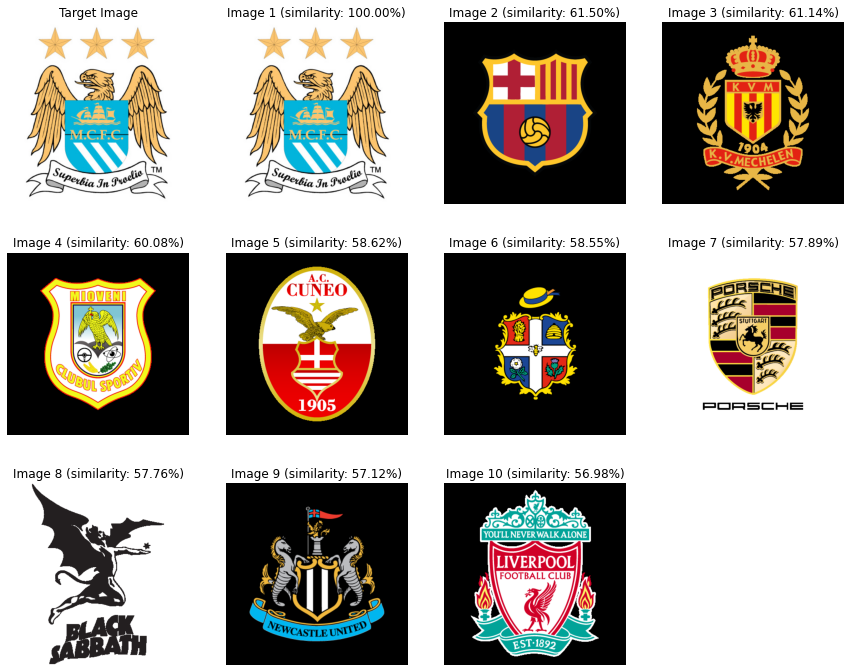

In [1]:
from efficientnet_pytorch import EfficientNet
#전체 이미지 DB에 있는 이미지들에서 유사도를 전부 측정한다.
def create_feature_extractor(model, return_nodes=None):
    if return_nodes is None:
        return_nodes = {'avgpool': 'avgpool'}

    return_nodes_output = {}
    for name, module in model.named_modules():
        if name in return_nodes:
            return_nodes_output[name] = module

    return return_nodes_output

model = EfficientNet.from_pretrained('efficientnet-b7')
model_features = create_feature_extractor(model,return_nodes={'avgpool':'avgpool'})
model.eval()    

import requests
import torchvision.transforms as T
from PIL import Image

def image_resize(image_url):                #이미지 url로 받아올 때 사용
    image = Image.open(requests.get(image_url, stream=True).raw)
    rgb_image = image.convert('RGB')
    preprocess = T.Compose([
        T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(224),
        T.ToTensor()]
    )
    return preprocess(rgb_image).unsqueeze(0)


from torchvision.transforms import Compose, Resize, ToTensor, Normalize

def image_resize_local(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error: Unable to open image. {e}")
        return None

    # 이미지 전처리: 크기 조정, 텐서 변환, 정규화
    preprocess = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    return preprocess(image)

from numpy import dot
from numpy.linalg import norm
import torch

def is_image_file(filename):
    # 파일 확장자 검사
    VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    _, ext = os.path.splitext(filename)
    return ext.lower() in VALID_EXTENSIONS

def cos_sim(A, B):
    return dot(A, B) / (norm(A) * norm(B))

def predict(image_path):
    resized_image = image_resize_local(image_path)
    if resized_image is None:
        return None
    model.eval()
    with torch.no_grad():
        image_transformed=resized_image.unsqueeze(0)
        predicted_result=model(image_transformed)
        image_feature=torch.flatten(predicted_result)
    return image_feature.detach().numpy()
    

root_dir = "C:\\Users\\DGU_ICE\\FindOwn\\ImageDB\\Logos"
#자신의 로컬에 있는 Image 파일 주소로 설정할 것.

import os
import re
from collections import defaultdict

# 타겟 이미지 경로
target_image_path = "C:\\Users\\DGU_ICE\\FindOwn\\ImageDB\\Logos\\manchester-city-logo-vector-download-400x400.jpg"

# 디렉토리에서 이미지 파일들 찾기
image_files = []
for (dirpath, dirnames, filenames) in os.walk(root_dir):
    for filename in filenames:
        if is_image_file(filename):
            image_files.append(os.path.join(dirpath, filename))

# 각 이미지와 타겟 이미지 간에 코사인 유사도 저장할 리스트 초기화
similarities = []

import cv2
import urllib.request
from matplotlib import pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# 타겟 이미지 특징 추출
def process_image(image_path):
    source_embedding = predict(image_path)
    if source_embedding is None or target_embedding is None:
        return image_path, None
    similarity = cos_sim(source_embedding,target_embedding)
    return image_path, similarity

import time
start_time=time.time()
target_embedding = predict(target_image_path)

# 각 이미지와 타겟 이미지의 유사도 계산
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_image, image_files))

# 유효한 결과만 저장하고 출력합니다.
top_results = []
for image_path, similarity in results:
    if similarity is not None:
        top_results.append((image_path, similarity))
    
top_results=sorted(top_results, key=lambda x: x[1],reverse=True)[:10]
elapsed_time = time.time() - start_time
print(f"병렬 처리 시간: {elapsed_time}초")
for image_path, similarity in top_results:
    print("Similarity between", image_path, "and target image:",similarity)

# 생성할 subplot의 행과 열 계산
n_rows = 3
n_cols = 4

# 하나의 figure에서 타겟 이미지와 top-10 이미지 출력
plt.figure(figsize=(15, 12))

# 타겟 이미지 출력
image = cv2.imread(target_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplot(n_rows, n_cols, 1)
plt.title("Target Image")
plt.imshow(image)
plt.axis('off')
top10_image_list=[]
# 상위 10개 이미지 출력
for i, (image_path, similarity) in enumerate(top_results):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    top10_image_list.append(image_path)
    plt.subplot(n_rows, n_cols, i + 2)
    plt.title(f"Image {i + 1} (similarity: {similarity * 100:.2f}%)")
    plt.imshow(image)
    plt.axis('off')

# plt.tight_layout()
plt.show()

### SSD Mobilenet V2를 사용한 버전


c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Detected class: bird
Detection box: tf.Tensor([0.09029639 0.11574456 0.8272132  0.8441014 ], shape=(4,), dtype=float32)
Score : tf.Tensor(0.47044414, shape=(), dtype=float32)


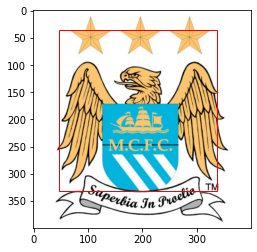

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_display_name_from_id(target_id):
    with open('mscoco_label_map.pbtxt', 'r') as f:
        lines = f.readlines()

    items = []
    item = {}
    for line in lines:
        if line.strip() == "}":
            items.append(item)
            item = {}
            continue

        if ":" in line:
            key, value = [x.strip() for x in line.split(":")]
            if key == "id":
                item[key] = int(value)
            else:
                # Remove quotes around the string
                item[key] = value.strip('"')

    # Now we have a list of dictionaries where each dictionary represents an item.
    # We can search this list to find the display_name corresponding to the target_id.
    
    for item in items:
        if 'id' in item and 'display_name' in item and item['id'] == target_id:
            return item['display_name']

# Load the model
model_id = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2'
model = hub.load(model_id)

# Load the target image
target_image_path = "C:\\Users\\DGU_ICE\\FindOwn\\ImageDB\\Logos\\manchester-city-logo-vector-download-400x400.jpg"
target_image = cv2.imread(target_image_path)

# Preprocess the target image
input_tensor = tf.convert_to_tensor(target_image, dtype=tf.uint8)
input_tensor = input_tensor[tf.newaxis, ...]

# Run detection on the target image
detections = model(input_tensor)

# Print detected classes and bounding boxes on the target image
fig, ax = plt.subplots(1)
ax.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))

for i in range(int(detections['num_detections'])):
    score = detections['detection_scores'][0][i]
    class_id = int(detections['detection_classes'][0][i])
    box = detections['detection_boxes'][0][i]

    if score > 0.35:  # You can adjust this threshold according to your needs.
        print(f"Detected class: {get_display_name_from_id(class_id)}")
        print("Detection box:", box)
        print("Score :",score)

        ymin, xmin, ymax, xmax = box.numpy()
        width, height = xmax - xmin, ymax - ymin

        # Add bounding box to the plot with label and confidence score        
        rect=patches.Rectangle((xmin*target_image.shape[1], ymin*target_image.shape[0]), 
                               width*target_image.shape[1], height*target_image.shape[0],
                               linewidth=1,
                               edgecolor='r',
                               facecolor='none')
        
        ax.add_patch(rect)
        
plt.show()  # Display the figure with bounding boxes.


### RetinaNet을 사용한 결과


C:\Users\sam\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sam\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Detected class: bird
Bounding box: tensor([ 42.0662,  96.9466, 119.9591, 318.0801], grad_fn=<UnbindBackward0>)
Detected Score: 0.12017975002527237
Detected class: bird
Bounding box: tensor([262.1343, 100.5075, 358.8377, 311.6572], grad_fn=<UnbindBackward0>)
Detected Score: 0.11471474170684814


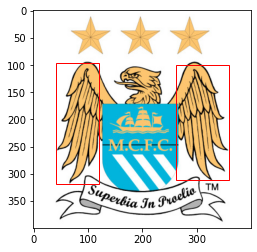

In [3]:
import torch
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_display_name_from_id(target_id):
    with open('mscoco_label_map.pbtxt', 'r') as f:
        lines = f.readlines()

    items = []
    item = {}
    for line in lines:
        if line.strip() == "}":
            items.append(item)
            item = {}
            continue

        if ":" in line:
            key, value = [x.strip() for x in line.split(":")]
            if key == "id":
                item[key] = int(value)
            else:
                # Remove quotes around the string
                item[key] = value.strip('"')

    # Now we have a list of dictionaries where each dictionary represents an item.
    # We can search this list to find the display_name corresponding to the target_id.
    
    for item in items:
        if 'id' in item and 'display_name' in item and item['id'] == target_id:
            return item['display_name']

target_image_path = "C:\\Users\\DGU_ICE\\FindOwn\\ImageDB\\Logos\\manchester-city-logo-vector-download-400x400.jpg"

# Load the model
model = retinanet_resnet50_fpn(pretrained=True)
model.eval()

# Load image and preprocess it
image = Image.open(target_image_path).convert("RGB")
image_tensor = F.to_tensor(image).unsqueeze(0)

# If you're using a GPU
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()
    model = model.cuda()

# Run detection (outputs is a list of dictionaries)
outputs = model(image_tensor)

fig, ax = plt.subplots(1)
ax.imshow(image)

# Print detected classes and bounding boxes
for i, output in enumerate(outputs):
    for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
        if label != 28 and score >0.1:  # You can adjust this threshold according to your needs.
            print(f"Detected class: {get_display_name_from_id(label)}")
            print(f"Bounding box: {box}")
            print(f"Detected Score: {score}")
            xmin, ymin, xmax, ymax = box.detach().cpu().numpy()
            
            rect=patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,
                                   edgecolor='r',facecolor='none')
            
            ax.add_patch(rect)

plt.show()  # Display the figure with bounding boxes.


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import json
import matplotlib.pyplot as plt
import cv2
# Load the model
import tensorflow_hub as hub
import tarfile
import os

# .tar.gz 파일의 경로
model_tar_path = "C:\\Users\\sam\\AppData\\Local\\Temp\\tfhub_modules\\faster_rcnn_openimages_v4_inception_resnet_v2_1.tar.gz"

# 압축 해제할 디렉토리의 경로 (예: model_directory)
model_dir = "C:\\Users\\sam\\AppData\\Local\\Temp\\tfhub_modules"

with tarfile.open(model_tar_path, 'r:gz') as tar:
    tar.extractall(path=model_dir)

# 압축 해제된 디렉토리 내에서 saved_model.pb 파일이 있는 디렉토리를 찾습니다.
for root, dirs, files in os.walk(model_dir):
    if 'saved_model.pb' in files:
        model_path = root

# 모델 로드
model = tf.saved_model.load(model_path)
# Load image and preprocess it
image = tf.image.decode_jpeg(tf.io.read_file(target_image_path))
if image.shape[-1] != 3:
    if image.shape[-1] == 1:
        # Convert grayscale to RGB
        image = tf.image.grayscale_to_rgb(image)
    elif image.shape[-1] == 4:
        # Convert RGBA to RGB by discarding the alpha channel
        image = image[..., :3]
        
image = tf.image.resize(image, [224, 224])
image = tf.cast(image, dtype=tf.float32)

image = image[tf.newaxis, ...] # Add batch dimension and normalize

# Run detection
detections = model.signatures['default'](tf.constant(image))

with open('coco-labels-2014_2017.txt','r') as f:
    mscoco_labels = [line.rstrip() for line in f]

# Print detected classes and bounding boxes
check = False
target_image_label = []
print(detections['detection_class_labels'].shape)
for i in range(len(detections['detection_scores'][0])):
    score = detections['detection_scores'][0][i]
    
    # Only consider detections with a confidence score of at least 0.5
    if score >= 0.4:
        class_id = int(detections['detection_classes'][0][i])
        box = detections['detection_boxes'][0][i]

        label = mscoco_labels[class_id]
        check = True
        print(f"Detected class: {label}")
        target_image_label.append(label)
        print("Detection score :", score.numpy())
if check == False:
    print("No object detected")

##############top 10 images object detected##############
final_labels=[]

for i in range(len(top10_image_list)):
    image = tf.image.decode_jpeg(tf.io.read_file(top10_image_list[i]))
    if image.shape[-1] != 3:
        if image.shape[-1] == 1:
            # Convert grayscale to RGB
            image = tf.image.grayscale_to_rgb(image)
        elif image.shape[-1] == 4:
            # Convert RGBA to RGB by discarding the alpha channel
            image = image[..., :3]
            
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, dtype=tf.uint8)

    image = image[tf.newaxis, ...] # Add batch dimension and normalize

    # Run detection
    detections = model.signatures['default'](tf.constant(image))
    check = False
    for j in range(int(detections['num_detections'])):
        score = detections['detection_scores'][0][j]
        
        # Only consider detections with a confidence score of at least 0.5
        if score >= 0.4:
            class_id = int(detections['detection_classes'][0][j])
            box = detections['detection_boxes'][0][j]
            label = mscoco_labels[class_id]
            check = True
            print(f"Detected class",top10_image_list[i],":" ,{label})
            final_labels.append(label)
            print("Detection score :", score.numpy())
    
endpoint = 0
final_result_images_index = []
print(final_labels)
for i in range(len(final_labels)):
    if final_labels[i] in target_image_label:
        print(final_labels[i],i)
        final_result_images_index.append(i)

if endpoint == 0:
    print("no images")
    
plt.subplot(1, len(final_result_images_index) + 1, 1)
plt.imshow(cv2.imread(target_image_path))
plt.axis('off')

for i in range(len(final_result_images_index)):
    plt.subplot(1, len(final_result_images_index) + 1, i+2)
    plt.imshow(cv2.imread(top10_image_list[final_result_images_index[i]]))
    plt.axis('off')
plt.show()

KeyError: 'default'